In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
"""
https://www.kaggle.com/apapiu/regularized-linear-models
linear regression , cv, xgboost, keras
"""

# %config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv") # 获取训练数据
test = pd.read_csv("./test.csv")   # 获取测试数据

In [3]:
train.head() # 查看前几行

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition'])) #将训练数据和测试数据的所有特征进行合并

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71813a16d8>,
      dtype=object)

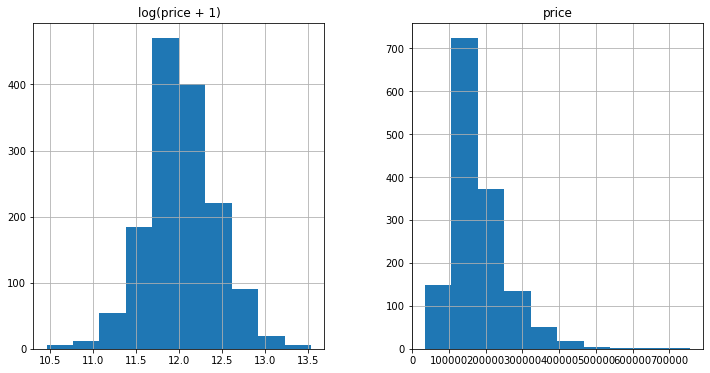

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0) # plt参数配置
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])}) # 原始label，和log变换后的label
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"]) # 对label进行变换

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index # 获取数值型的列索引

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness计算数值特征的偏度
skewed_feats = skewed_feats[skewed_feats > 0.75] # 获取偏度大于0.75的特征列
skewed_feats = skewed_feats.index # 获取列索引

all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) # 对偏度较高的特征进行log变换

In [7]:
all_data = pd.get_dummies(all_data) # one-hot编码

In [8]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean()) # 使用列均值填补缺失

In [9]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]  # 获取训练数据
X_test = all_data[train.shape[0]:]   # 获取测试数据
y = train.SalePrice    # 训练数据的label

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):  # 交叉验证
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [11]:
model_ridge = Ridge() 构建岭回归模型

In [12]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas] # 搜索最佳参数进行模型训练

Text(0, 0.5, 'rmse')

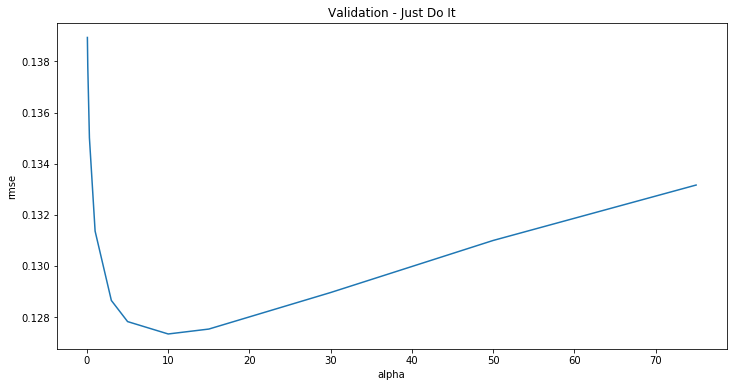

In [13]:
cv_ridge = pd.Series(cv_ridge, index = alphas) # 打印训练结果
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [14]:
cv_ridge.min() # 最小误差

0.12733734668670757

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y) # 拉索回归交叉验证，搜索最佳参数进行训练

/work/.pylib/3/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [16]:
rmse_cv(model_lasso).mean() # 通过交叉验证，计算误差

/work/.pylib/3/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/work/.pylib/3/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/work/.pylib/3/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/work/.pylib/3/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/work/.pylib/3/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will c

0.12314421090977457

In [17]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns) #  特征权重

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [19]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)]) # 取最重要和最次要的10个特征权重合并

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

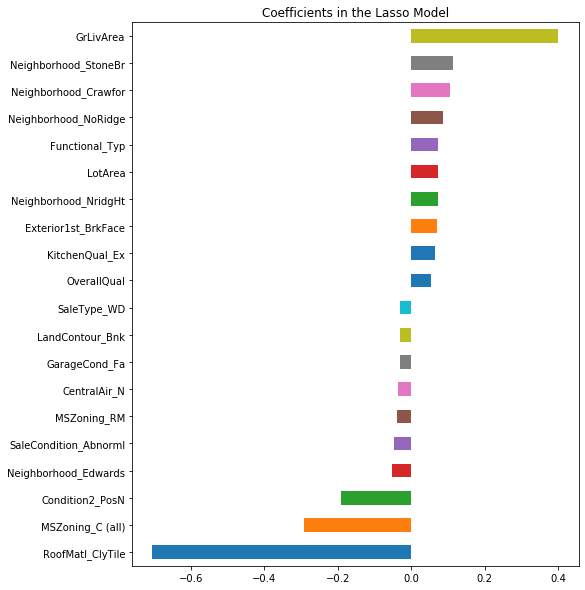

In [20]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh") # 画出特征权重图
plt.title("Coefficients in the Lasso Model")

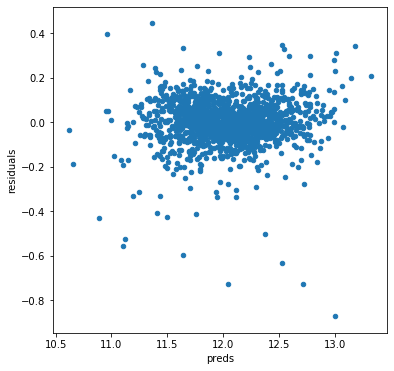

In [21]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y}) # 创建df,包含预测结果和真实值
preds["residuals"] = preds["true"] - preds["preds"] # 计算真实值与预测值之间的残差
preds.plot(x = "preds", y = "residuals",kind = "scatter") # 画预测值与残差之间的散点图

In [22]:
import xgboost as xgb

In [23]:
dtrain = xgb.DMatrix(X_train, label = y) # 构建训练集
dtest = xgb.DMatrix(X_test)       # 构建测试集

params = {"max_depth":2, "eta":0.1} # xgb参数配置
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100) # 通过交叉验证进行xgb训练

[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[23:12:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[

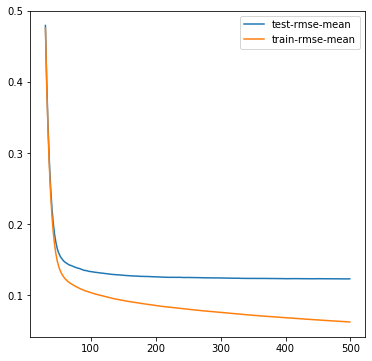

In [24]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot() # 取模型训练第30轮之后的训练误差、测试误差，画图

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y) # xgb训练 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [26]:
xgb_preds = np.expm1(model_xgb.predict(X_test)) # xgb在测试集上预测，并还原结果
lasso_preds = np.expm1(model_lasso.predict(X_test)) # lasso回归在测试集上预测，并还原结果

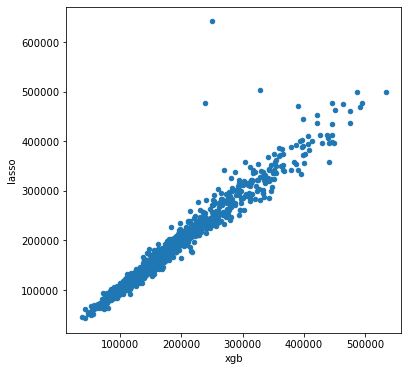

In [27]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds}) # 创建df,使用xgb预测结果和lasso预测结果
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")  # 使用预测结果画散点图

In [28]:
preds = 0.7*lasso_preds + 0.3*xgb_preds # 对预测结果进行加权求和

In [29]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False) # 保存预测结果

In [30]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/py

In [31]:
X_train = StandardScaler().fit_transform(X_train)

In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [33]:
X_tr.shape

(1095, 288)

In [34]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [35]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [37]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/1
1095/1095 [==============================] - 0s 152us/step - loss: 147.0249 - val_loss: 149.9532


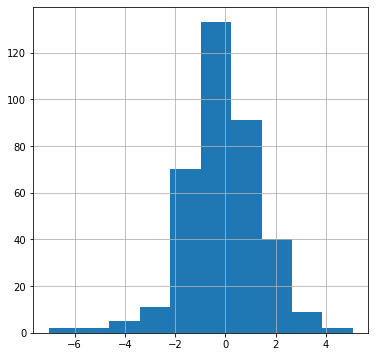

In [38]:
pd.Series(model.predict(X_val)[:,0]).hist()